In [308]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import os, json, joblib
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
from pathlib import Path
import unicodedata as ud
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, StratifiedGroupKFold
import optuna
from sklearn.metrics import mean_squared_error,  mean_squared_log_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Tratamento de dados

### Conectando com o Banco de Dados

In [11]:
load_dotenv()

HOST = os.getenv("PGHOST")
PORT = os.getenv("PGPORT")
DB   = os.getenv("PGDATABASE")
USR  = os.getenv("PGUSER")
PWD  = os.getenv("PGPASSWORD")

In [14]:
# 1) Caminho .env local
ENV_PATH = Path(r"C:\Users\cicer\Documents\Case Técnico Paipe\Análise Exploratória\.env")
print("Arquivo .env existe?", ENV_PATH.exists(), "\nCaminho:", ENV_PATH)

# 2) Carrega o .env
load_dotenv(dotenv_path=ENV_PATH, override=True)

# 3) Confere o que foi lido
cfg = {k: os.getenv(k) for k in ["PGHOST", "PGPORT", "PGDATABASE", "PGUSER"]}
print(cfg, "| PGPASSWORD set?", bool(os.getenv("PGPASSWORD")))


Arquivo .env existe? True 
Caminho: C:\Users\cicer\Documents\Case Técnico Paipe\Análise Exploratória\.env
{'PGHOST': 'localhost', 'PGPORT': '5432', 'PGDATABASE': 'PaipeTech', 'PGUSER': 'postgres'} | PGPASSWORD set? True


In [17]:
HOST = os.getenv("PGHOST", "localhost")
PORT = int(os.getenv("PGPORT") or 5432)
DB   = os.getenv("PGDATABASE")
USR  = os.getenv("PGUSER")
PWD  = os.getenv("PGPASSWORD")

url = URL.create(
    "postgresql+psycopg2",
    username=USR,
    password=PWD,   
    host=HOST,
    port=PORT,
    database=DB,
)

engine = create_engine(url, pool_pre_ping=True)

# teste rápido
with engine.begin() as conn:
    print("DB atual:", conn.execute(text("SELECT current_database()")).scalar())
    print("Versão:",  conn.execute(text("SELECT version()")).scalar().splitlines()[0])


DB atual: PaipeTech
Versão: PostgreSQL 18.0 on x86_64-windows, compiled by msvc-19.44.35215, 64-bit


In [20]:
df = pd.read_sql(text("SELECT * FROM public.df_train"), engine)

## Pré Processamento

### Transformando as variáveis necessárias em int

In [30]:
cols_int = [
    "mintimetoneareststation", "maxtimetoneareststation", "totalfloorarea",
    "buildingyear", "coverageratio", "floorarearatio", "buildingyear"
]
for c in cols_int:
    df[c] = (pd.to_numeric(df[c], errors="coerce")    
               .round()                              
               .astype("Int64")) 

### Dropando as 3 colunas com maior porcentagem de nulos, ela não agregam informação ao modelo

In [41]:
((df.isna().sum() / len(df)) * 100).sort_values(ascending=False).head(3) # Percentual de nulos em cada feature

remarks          92.191170
pricepertsubo    80.451024
unitprice        80.451024
dtype: float64

In [44]:
df.drop(columns=['unitprice', 'pricepertsubo', 'remarks'], inplace = True)

### Criando features

In [50]:
df["time_to_station_mean"] = df[["mintimetoneareststation","maxtimetoneareststation"]].mean(axis=1)

In [53]:
df['district_uid'] = df['municipalitycode'].astype(str) + '|' + df['districtname']

In [68]:
df["log_totalfloorarea"] = np.log1p(df["totalfloorarea"])
df["log_area"] = np.log1p(df["area"])
df["log_frontage"] = np.log1p(df["frontage"])
df["log_breadth"] = np.log1p(df["breadth"])

In [73]:
df.columns

Index(['id', 'type', 'region', 'municipalitycode', 'prefecture',
       'municipality', 'districtname', 'neareststation',
       'timetoneareststation', 'mintimetoneareststation',
       'maxtimetoneareststation', 'floorplan', 'area', 'areaisgreaterflag',
       'landshape', 'frontage', 'frontageisgreaterflag', 'totalfloorarea',
       'totalfloorareaisgreaterflag', 'buildingyear', 'prewarbuilding',
       'structure', 'use', 'purpose', 'direction', 'classification', 'breadth',
       'cityplanning', 'coverageratio', 'floorarearatio', 'period', 'year',
       'quarter', 'renovation', 'tradeprice', 'time_to_station_mean',
       'district_uid', 'log_totalfloorarea', 'log_area', 'log_frontage',
       'log_breadth'],
      dtype='object')

### Transformando 0 em Nan em variáveis numéricas, pois modelos baseados em árvores lidam melhor com Nan

In [81]:
df[["mintimetoneareststation", 'maxtimetoneareststation', 'time_to_station_mean']] = df[["mintimetoneareststation", 'maxtimetoneareststation', 'time_to_station_mean']].replace(0, np.nan)

### Tratando colunas categóricas para usar no modelo

In [101]:
cat_cols = [['type', 'region', 'municipality', 'districtname', 'floorplan', 'landshape',
       'structure', 'use', 'purpose', 'direction', 'classification',
       'cityplanning', 'renovation', 'district_uid']]

In [154]:
for c in cat_cols:
    df[c] = df[c].astype("category")

### Separando variáveis de treino e teste

**Separando os dados com split 80/20 estratificado por ano. Como os dados de teste contém imóveis de todos os anos, não é possível considerar uma linha temporal**

In [344]:
strata = df["year"].astype(int)

# X = df[['type', 'region', 'municipalitycode','municipality', 'districtname', 'mintimetoneareststation',
#        'maxtimetoneareststation', 'floorplan', 'area', 'landshape', 'frontage', 'totalfloorarea', 'buildingyear',
#        'structure', 'use', 'purpose', 'direction', 'classification', 'breadth',  'cityplanning', 'coverageratio',
#        'floorarearatio', 'year', 'quarter', 'renovation', 'time_to_station_mean', 'district_uid', 'log_totalfloorarea',
#        'log_area', 'log_frontage', 'log_breadth']]

X = df[['type', 'region', 'municipalitycode','municipality', 'districtname', 'mintimetoneareststation',
       'maxtimetoneareststation', 'floorplan', 'landshape', 'buildingyear',
       'structure', 'use', 'purpose', 'direction', 'classification',  'cityplanning', 'coverageratio',
       'floorarearatio', 'year', 'quarter', 'renovation', 'time_to_station_mean', 'district_uid', 'log_totalfloorarea',
       'log_area', 'log_frontage', 'log_breadth']]

y = pd.DataFrame(df.tradeprice)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=strata
)

print(X_train.shape, X_test.shape)


(260208, 27) (65052, 27)


In [345]:
y_train["y_log"] = np.log1p(y_train["tradeprice"])
y_test["y_log"] = np.log1p(y_test["tradeprice"])

y_train.drop(columns='tradeprice', inplace = True)
y_test.drop(columns='tradeprice', inplace = True)

### Separando os folds para cross validation

**Usando o Kfold para validação cruzada, porém, cada fold terá uma faixa do tempo, para o modelo tentar captar estes movimentos**

In [350]:
strata  = X_train["year"].astype("Int64")         
groups  = X_train["district_uid"].astype("string").fillna("Missing")

mask_ok   = strata.notna() & groups.notna()
X_tr_cv   = X_train.loc[mask_ok].copy()
y_tr_cv   = y_train.loc[mask_ok].astype(float).copy()
strata_ok = strata.loc[mask_ok].astype(int)
groups_ok = groups.loc[mask_ok]

# conferir se os anos estão corretos
print("anos em strata_ok:", int(strata_ok.min()), "→", int(strata_ok.max()))
print("anos em X_tr_cv  :", int(X_tr_cv["year"].min()), "→", int(X_tr_cv["year"].max()))

min_per_class = strata_ok.value_counts().min()
n_splits = min(5, int(min_per_class))
if n_splits < 2:
    raise ValueError(f"Algum ano tem <2 amostras; n_splits={n_splits} é inválido.")

sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = [(tr, va) for tr, va in sgkf.split(X_tr_cv, y=strata_ok, groups=groups_ok)]

for i, (tr, va) in enumerate(folds, 1):
    print(f"Fold {i}: treino={len(tr):,} | validação={len(va):,} | "
          f"anos_validação={sorted(strata_ok.iloc[va].unique().tolist())} | "
          f"distritos_validação={groups_ok.iloc[va].nunique()}")


anos em strata_ok: 2005 → 2019
anos em X_tr_cv  : 2005 → 2019
Fold 1: treino=209,306 | validação=50,902 | anos_validação=[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] | distritos_validação=310
Fold 2: treino=207,663 | validação=52,545 | anos_validação=[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] | distritos_validação=317
Fold 3: treino=208,053 | validação=52,155 | anos_validação=[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] | distritos_validação=320
Fold 4: treino=205,877 | validação=54,331 | anos_validação=[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] | distritos_validação=321
Fold 5: treino=209,933 | validação=50,275 | anos_validação=[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] | distritos_validação=324


**retirando o id**

### Utilizando o Optuna para a tunagem de hiper Parâmetros

In [364]:
PRIMARY_METRIC = "rmsle"   # ou "mape"
N_TRIALS = 5
SEED = 42

def rmsle_raw(y_true_raw, y_pred_raw):
    y_pred_raw = np.maximum(y_pred_raw, 0)
    return float(np.sqrt(mean_squared_log_error(y_true_raw, y_pred_raw)))

def mape_raw(y_true_raw, y_pred_raw):
    y_pred_raw = np.maximum(y_pred_raw, 0)
    return float(mean_absolute_percentage_error(y_true_raw, y_pred_raw) * 100)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000, 2500]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1]),
        "num_leaves": trial.suggest_categorical("num_leaves", [31, 100]),
        "max_depth": trial.suggest_categorical("max_depth", [6, 10,]),
        "subsample": trial.suggest_categorical("subsample", [0.7, 1.0]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.7, 1.0]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [20, 60]),
        "reg_alpha": trial.suggest_categorical("reg_alpha", [0.0, 0.5]),
        "reg_lambda": trial.suggest_categorical("reg_lambda", [0.0,0.5]),
        "random_state": SEED,
        "n_jobs": -1,
    }

    rmsle_scores, mape_scores = [], []

    for fold, (tr, va) in enumerate(folds, 1):
        X_tr, X_va = X_train.iloc[tr].copy(), X_train.iloc[va].copy()

        y_tr_log = y_train.iloc[tr].astype(float).copy()
        y_va_log = y_train.iloc[va].astype(float).copy()

        # para métricas na escala original
        y_va_raw = np.expm1(y_va_log.values)

        # garantir categóricas
        for dfx in (X_tr, X_va):
            for c in dfx.select_dtypes(include=["object","string"]).columns:
                dfx[c] = dfx[c].astype("category")

        model = LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],   
            eval_metric="rmse",            # rmse no log == rmsle na escala original
            callbacks=[
                lgb.early_stopping(stopping_rounds=200, verbose=False),
                lgb.log_evaluation(period=0),
            ],
        )

        # predição -> volta para escala original
        pred_log = model.predict(X_va, num_iteration=model.best_iteration_)
        pred_raw = np.expm1(pred_log)

        rmsle_scores.append(rmsle_raw(y_va_raw, pred_raw))
        mape_scores.append(mape_raw(y_va_raw, pred_raw))

    trial.set_user_attr("mean_rmsle", float(np.mean(rmsle_scores)))
    trial.set_user_attr("mean_mape",  float(np.mean(mape_scores)))

    return float(np.mean(rmsle_scores) if PRIMARY_METRIC == "rmsle" else np.mean(mape_scores))

sampler = optuna.samplers.TPESampler(seed=SEED)
study_lgbm = optuna.create_study(direction="minimize", sampler=sampler)
study_lgbm.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("✅ Melhor trial:", study_lgbm.best_trial.number)
print("✅ RMSLE médio:", study_lgbm.best_trial.user_attrs["mean_rmsle"])
print("✅ MAPE médio :", study_lgbm.best_trial.user_attrs["mean_mape"])
print("✅ Parâmetros:")
for k, v in study_lgbm.best_params.items():
    print(f"  {k}: {v}")


[I 2025-10-06 01:03:14,849] A new study created in memory with name: no-name-3e6e9357-440c-42e8-829a-9c3b0fa671ee


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 209306, number of used features: 26
[LightGBM] [Info] Start training from score 17.366642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

KeyboardInterrupt: 

In [ ]:
### Salvando pkl do modelo e dos melhores parâmetros, além da feature importance

In [366]:
SAVE_DIR = "models_lgbm"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) melhores parâmetros do Optuna
best_params = study_lgbm.best_params.copy()
best_params.update({"random_state": 42, "n_jobs": -1})

# garante dtypes (categóricas) no X_train
for c in X_train.select_dtypes(include=["object","string"]).columns:
    X_train[c] = X_train[c].astype("category")

#  treina modelo final
y_tr_log = y_train.astype(float)
final_lgbm = LGBMRegressor(**best_params)
final_lgbm.fit(X_train, y_tr_log)

# salva parâmetros e modelo
with open(f"{SAVE_DIR}/lgbm_best_params.json", "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)
joblib.dump(final_lgbm, f"{SAVE_DIR}/lgbm_model_final.pkl")

#  importâncias de features
fi = pd.Series(final_lgbm.feature_importances_, index=X_train.columns, name="importance") \
       .sort_values(ascending=False).to_frame()
fi.to_csv(f"{SAVE_DIR}/feature_importances.csv", index_label="feature")

#  metadados para inferência (ordem das colunas + níveis categóricos)
meta = {
    "X_cols": list(X_train.columns),
    "categorical_levels": {
        c: list(X_train[c].cat.categories) for c in X_train.select_dtypes("category").columns
    },
}
with open(f"{SAVE_DIR}/inference_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

#  salva o estudo do Optuna
joblib.dump(study_lgbm, f"{SAVE_DIR}/optuna_study.pkl")

print("✅ Parâmetros salvos em:", f"{SAVE_DIR}/lgbm_best_params.json")
print("✅ Modelo salvo em    :", f"{SAVE_DIR}/lgbm_model_final.pkl")
print("✅ Importâncias em    :", f"{SAVE_DIR}/feature_importances.csv")
print("✅ Metadados em       :", f"{SAVE_DIR}/inference_meta.json")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 260208, number of used features: 26
[LightGBM] [Info] Start training from score 17.369426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [386]:
X_test.drop(columns='district_uid', inplace=True)

In [388]:
final_lgbm = joblib.load(os.path.join(SAVE_DIR, "lgbm_model_final.pkl"))
meta_path  = os.path.join(SAVE_DIR, "inference_meta.json")
meta = None
if os.path.exists(meta_path):
    with open(meta_path, "r", encoding="utf-8") as f:
        meta = json.load(f)

# preparar X_test 
X_te = X_test.copy()
for c in X_te.select_dtypes(include=["object","string"]).columns:
    X_te[c] = X_te[c].astype("category")

# prever 
y_pred_log = final_lgbm.predict(X_te)
y_pred     = np.expm1(y_pred_log)

# métricas 
y_true = np.expm1(y_test.values.astype(float))
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np
y_pred = np.maximum(y_pred, 0)
print("RMSLE:", np.sqrt(mean_squared_log_error(y_true, y_pred)))
print("RMSE :", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAPE :", mean_absolute_percentage_error(y_true, y_pred) * 100)


RMSLE: 0.3142732134078924
RMSE : 187797136.6937438
MAPE : 28.440463680609724


In [401]:
SEED = 42


#Carregar dados e meta
train = pd.read_sql(text("SELECT * FROM public.df_train"), engine)

# padronizar nomes de colunas 
train.columns = [c.lower() for c in train.columns]

with open(os.path.join(BASE, "inference_meta.json"), "r", encoding="utf-8") as f:
    meta = json.load(f)

X_COLS     = meta["X_cols"]
CAT_LEVELS = meta["categorical_levels"]


# Funções de features 
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # tempo médio até estação
    base_time = pd.to_numeric(df.get("timetoneareststation"), errors="coerce")
    min_t = pd.to_numeric(df.get("mintimetoneareststation"), errors="coerce")
    max_t = pd.to_numeric(df.get("maxtimetoneareststation"), errors="coerce")
    time_mean = base_time.copy()
    if time_mean is None or isinstance(time_mean, float):
        time_mean = pd.Series(np.nan, index=df.index)
    mask_nan = time_mean.isna()
    time_mean.loc[mask_nan] = (min_t[mask_nan] + max_t[mask_nan]) / 2.0
    df["time_to_station_mean"] = time_mean

    # logs 
    for src, dst in [
        ("totalfloorarea", "log_totalfloorarea"),
        ("area",           "log_area"),
        ("frontage",       "log_frontage"),
        ("breadth",        "log_breadth"),
    ]:
        if src in df.columns:
            df[dst] = np.log1p(pd.to_numeric(df[src], errors="coerce").fillna(0))

    # numéricos básicos
    for c in ["buildingyear","coverageratio","floorarearatio","year","quarter","municipalitycode"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # normaliza renovation
    if "renovation" in df.columns:
        df["renovation"] = (
            df["renovation"].astype(str).str.strip()
              .replace({"Yes":"Done","No":"Not yet","nan":"Not yet","NaN":"Not yet"})
        )

    for c, levels in CAT_LEVELS.items():
        if c in df.columns:
            df[c] = pd.Categorical(df[c].astype(str), categories=levels)

    
    for c in X_COLS:
        if c not in df.columns:
            df[c] = np.nan

    return df

train_f = build_features(train)

for col in ["log_totalfloorarea","log_area","log_frontage","log_breadth"]:
    if col in train_f.columns:
        bad = ~np.isfinite(train_f[col]) | train_f[col].isna()
        if bad.any():
            train_f.loc[bad, col] = 0.0

# ## X/y e split (treino/validação)

y_log = np.log1p(pd.to_numeric(train_f["tradeprice"], errors="coerce"))
X_all = train_f[X_COLS].copy()

# dtypes categóricos para o LightGBM
for c in X_all.columns:
    if str(X_all[c].dtype) in ["object","string"]:
        X_all[c] = X_all[c].astype("category")

# split estratificado por ano 
strata = pd.to_numeric(train_f["year"], errors="coerce").fillna(-1).astype(int)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_all, y_log, test_size=0.2, random_state=SEED, stratify=strata
)


# Parâmetros e treino
best_params_path = os.path.join(BASE, "lgbm_best_params.json")
if os.path.exists(best_params_path):
    with open(best_params_path, "r", encoding="utf-8") as f:
        best_params = json.load(f)
else:
    best_params = dict(
        n_estimators=800, learning_rate=0.08,
        num_leaves=64, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8,
        min_child_samples=40
    )
best_params.update({"random_state": SEED, "n_jobs": -1})

model = LGBMRegressor(**best_params)
model.fit(X_tr, y_tr)


# Avaliação 

pred_va_log = model.predict(X_va)             
pred_va     = np.maximum(np.expm1(pred_va_log), 0)
y_va_raw    = np.expm1(y_va)

rmsle = math.sqrt(mean_squared_log_error(y_va_raw, pred_va))
rmse  = math.sqrt(mean_squared_error(y_va_raw, pred_va))
mape  = mean_absolute_percentage_error(y_va_raw, pred_va) * 100

print(f"RMSLE: {rmsle:.4f}")
print(f"RMSE : {rmse:,.0f}")
print(f"MAPE : {mape:.2f}%")

# salva as previsões de validação para inspecionar depois
val_preds_df = pd.DataFrame({
    "y_true": y_va_raw,
    "y_pred": pred_va
}).reset_index(drop=True)
val_preds_df.head()


# Modelo final
final_model = LGBMRegressor(**best_params).fit(X_all, y_log)

SAVE_DIR = os.path.join(BASE, "models_lgbm_corrigido")
os.makedirs(SAVE_DIR, exist_ok=True)

import joblib
joblib.dump(final_model, os.path.join(SAVE_DIR, "lgbm_model_final.pkl"))

fi = pd.DataFrame({"feature": X_COLS, "importance": final_model.feature_importances_}).sort_values("importance", ascending=False)
fi.to_csv(os.path.join(SAVE_DIR, "feature_importances.csv"), index=False)

meta_out = {"X_cols": X_COLS, "categorical_levels": CAT_LEVELS}
with open(os.path.join(SAVE_DIR, "inference_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta_out, f, ensure_ascii=False, indent=2)

print("✅ Artefatos salvos em:", SAVE_DIR)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2525
[LightGBM] [Info] Number of data points in the train set: 260208, number of used features: 26
[LightGBM] [Info] Start training from score 17.369426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [405]:
# OPTUNA: busca de hiperparâmetros com RMSLE 
import optuna, math, numpy as np, json, os
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

SEED = 42

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 512),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": SEED,
        "n_jobs": -1,
        "deterministic": True,
        "force_col_wise": True,
    }

    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="rmse",
        callbacks=[]
    )

    # avalia RMSLE na escala original
    pred = np.maximum(np.expm1(model.predict(X_va)), 0)
    true = np.expm1(y_va)
    rmsle = math.sqrt(mean_squared_log_error(true, pred))
    return rmsle

study = optuna.create_study(direction="minimize", study_name="lgbm_rmsle_holdout")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best RMSLE:", study.best_value)
print("Best params:", study.best_params)

# salvar melhores params
os.makedirs(BASE, exist_ok=True)
with open(os.path.join(BASE, "lgbm_best_params.json"), "w", encoding="utf-8") as f:
    json.dump(study.best_params, f, ensure_ascii=False, indent=2)


[I 2025-10-06 05:06:04,048] A new study created in memory with name: lgbm_rmsle_holdout


  0%|          | 0/40 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 2525
[LightGBM] [Info] Number of data points in the train set: 260208, number of used features: 26
[LightGBM] [Info] Start training from score 17.369426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [420]:
# usa os melhores params do Optuna
with open(os.path.join(BASE, "lgbm_best_params.json"), "r", encoding="utf-8") as f:
    best_params = json.load(f)
best_params.update({"random_state": SEED, "n_jobs": -1, "deterministic": True, "force_col_wise": True})

model = LGBMRegressor(**best_params)
model.fit(X_tr, y_tr)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 2525
[LightGBM] [Info] Number of data points in the train set: 260208, number of used features: 26
[LightGBM] [Info] Start training from score 17.369426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor(colsample_bytree=0.6022363443400984, deterministic=True,
              force_col_wise=True, learning_rate=0.0163897201923439,
              max_depth=16, min_child_samples=26, n_estimators=1562, n_jobs=-1,
              num_leaves=224, random_state=42, reg_alpha=4.40336217103809,
              reg_lambda=3.870691511958669, subsample=0.9173361894816632)

In [421]:
pred_va_log = model.predict(X_va)             # <- predict em X_va
pred_va     = np.maximum(np.expm1(pred_va_log), 0)
y_va_raw    = np.expm1(y_va)

rmsle = math.sqrt(mean_squared_log_error(y_va_raw, pred_va))
rmse  = math.sqrt(mean_squared_error(y_va_raw, pred_va))
mape  = mean_absolute_percentage_error(y_va_raw, pred_va) * 100

print(f"RMSLE: {rmsle:.4f}")
print(f"RMSE : {rmse:,.0f}")
print(f"MAPE : {mape:.2f}%")

RMSLE: 0.3067
RMSE : 181,311,149
MAPE : 27.56%


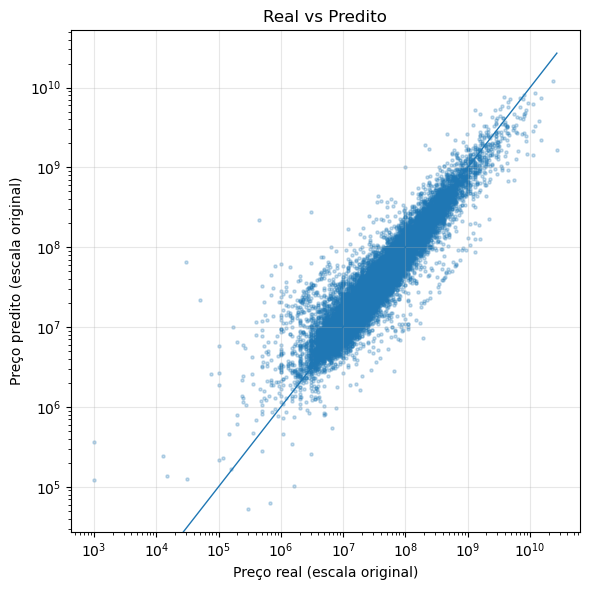

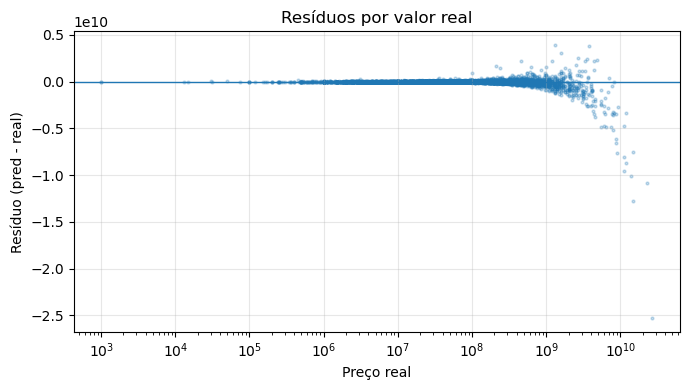

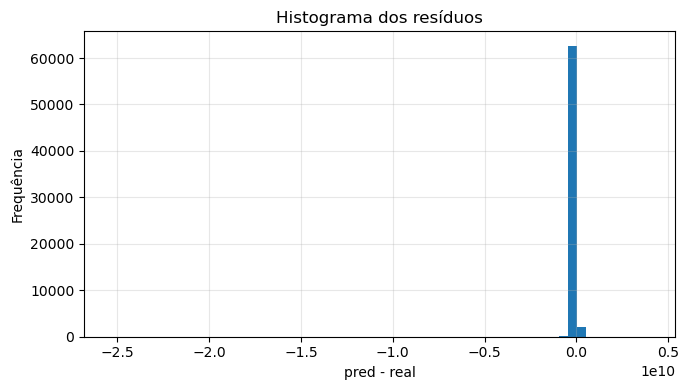

RMSLE: 0.3067 | MAPE: 27.56%


In [444]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error
import math

# alinhar escalas
y_true = np.expm1(y_va)   # real na escala original
y_pred = pred_va          # já está na escala original (expm1 do modelo)

# 1) Scatter y_true vs y_pred com linha y=x
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=5, alpha=0.25)
m = float(max(y_true.max(), y_pred.max()))
plt.plot([0, m], [0, m], linewidth=1)  # linha de igualdade
plt.xscale("log"); plt.yscale("log")   # remova se quiser linear
plt.xlabel("Preço real (escala original)")
plt.ylabel("Preço predito (escala original)")
plt.title("Real vs Predito")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 2) Resíduos (y_pred - y_true)
res = y_pred - y_true
plt.figure(figsize=(7,4))
plt.scatter(y_true, res, s=4, alpha=0.25)
plt.axhline(0, linewidth=1)
plt.xscale("log")  # preços variam muito; remova se quiser
plt.xlabel("Preço real")
plt.ylabel("Resíduo (pred - real)")
plt.title("Resíduos por valor real")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# 3) Histograma dos resíduos
plt.figure(figsize=(7,4))
plt.hist(res, bins=60)
plt.title("Histograma dos resíduos")
plt.xlabel("pred - real"); plt.ylabel("Frequência")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# (opcional) Métricas para checar
rmsle = math.sqrt(mean_squared_log_error(y_true, y_pred))
mape  = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"RMSLE: {rmsle:.4f} | MAPE: {mape:.2f}%")


In [424]:
import os, joblib

SAVE_DIR = BASE if os.path.isdir(BASE) else "."
os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(model, os.path.join(SAVE_DIR, "lgbm_model_final.pkl"))
print("Modelo salvo em:", os.path.join(SAVE_DIR, "lgbm_model_final.pkl"))


Modelo salvo em: models_lgbm/lgbm_model_final.pkl


In [408]:
# salvar melhores params
os.makedirs(BASE, exist_ok=True)
with open(os.path.join(BASE, "lgbm_best_params_robust.json"), "w", encoding="utf-8") as f:
    json.dump(study.best_params, f, ensure_ascii=False, indent=2)

In [ ]:
SEED = 42
strata = pd.to_numeric(train_f["year"], errors="coerce").fillna(-1).astype(int)
groups = train_f["districtname"].astype(str).fillna("Missing")

def objective_cv(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 600, 2500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 512),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": SEED,
        "n_jobs": -1,
        "deterministic": True,
        "force_col_wise": True,
    }

    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
    rmsle_scores = []

    for tr_idx, va_idx in cv.split(X_all, strata, groups):
        X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        y_tr, y_va = y_log.iloc[tr_idx], y_log.iloc[va_idx]

        model = LGBMRegressor(**params)
        model.fit(X_tr, y_tr)

        pred = np.maximum(np.expm1(model.predict(X_va)), 0)
        true = np.expm1(y_va)
        rmsle = math.sqrt(mean_squared_log_error(true, pred))
        rmsle_scores.append(rmsle)

    return float(np.mean(rmsle_scores))

study = optuna.create_study(direction="minimize", study_name="lgbm_rmsle_cv")
study.optimize(objective_cv, n_trials=40, show_progress_bar=True)

print("Best RMSLE (CV mean):", study.best_value)
print("Best params:", study.best_params)

# salvar melhores params
os.makedirs(BASE, exist_ok=True)
with open(os.path.join(BASE, "lgbm_best_params_robust.json"), "w", encoding="utf-8") as f:
    json.dump(study.best_params, f, ensure_ascii=False, indent=2)


[I 2025-10-06 06:02:29,080] A new study created in memory with name: lgbm_rmsle_cv


  0%|          | 0/40 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 264755, number of used features: 26
[LightGBM] [Info] Start training from score 17.363582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [412]:
# usa os melhores params do Optuna 
with open(os.path.join(BASE, "lgbm_best_params_robust.json"), "r", encoding="utf-8") as f:
    best_params = json.load(f)
best_params.update({"random_state": SEED, "n_jobs": -1, "deterministic": True, "force_col_wise": True})

model_robust = LGBMRegressor(**best_params)
model_robust.fit(X_tr, y_tr)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 2525
[LightGBM] [Info] Number of data points in the train set: 260208, number of used features: 26
[LightGBM] [Info] Start training from score 17.369426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor(colsample_bytree=0.614149097653217, deterministic=True,
              force_col_wise=True, learning_rate=0.030881083253450972,
              max_depth=10, min_child_samples=176, n_estimators=2443, n_jobs=-1,
              num_leaves=37, random_state=42, reg_alpha=3.8566977302116223,
              reg_lambda=3.2152933824176144, subsample=0.7202434324311636)

In [414]:
pred_va_log = model_robust.predict(X_va)             # <- predict em X_va
pred_va     = np.maximum(np.expm1(pred_va_log), 0)
y_va_raw    = np.expm1(y_va)

rmsle = math.sqrt(mean_squared_log_error(y_va_raw, pred_va))
rmse  = math.sqrt(mean_squared_error(y_va_raw, pred_va))
mape  = mean_absolute_percentage_error(y_va_raw, pred_va) * 100

print(f"RMSLE: {rmsle:.4f}")
print(f"RMSE : {rmse:,.0f}")
print(f"MAPE : {mape:.2f}%")

RMSLE: 0.3094
RMSE : 181,898,837
MAPE : 28.30%
